# Installation de l'environnement

Utiliser python2

## Darknet

In [6]:
%%bash
git clone https://github.com/Ramesh-X/pyyolo.git
cd pyyolo
GPU=1 python setup.py build_ext
pip install -U .

running build_ext
Processing /content/pyyolo
  Created wheel for pyyolo: filename=pyyolo-1.1-cp27-none-any.whl size=1382508 sha256=3dff9cfbeb8c23b684d9b3dfc21560ecec375622477ad1c7c39a4054452d51b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-peRHjW/wheels/fc/28/83/5971196051e9eab78fb47883562e128dea93812ae29ba913ff
Successfully built pyyolo
  Found existing installation: pyyolo 1.1
    Uninstalling pyyolo-1.1:
      Successfully uninstalled pyyolo-1.1


fatal: destination path 'pyyolo' already exists and is not an empty directory.


Téléchargement des fichiers de configuration et des poids pour YOLOv3 et Tiny YOLOv3 :

In [7]:
%%bash
cd pyyolo/darknet
mkdir weights
cd weights
wget https://pjreddie.com/media/files/yolov3.weights
wget https://pjreddie.com/media/files/yolov3-tiny.weights

mkdir: cannot create directory ‘weights’: File exists
--2020-02-04 18:14:44--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

     0K .......... .......... .......... .......... ..........  0%  682K 5m55s
    50K .......... .......... .......... .......... ..........  0%  678K 5m56s
   100K .......... .......... .......... .......... ..........  0% 50.5M 3m59s
   150K .......... .......... .......... .......... ..........  0% 96.2M 3m0s
   200K .......... .......... .......... .......... ..........  0%  688K 3m34s
   250K .......... .......... .......... .......... ..........  0% 74.8M 2m59s
   300K .......... .......... .......... .......... ..........  0% 69.3M 2m34s
   350K .......... .......... .......... .......... .........

## Dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%%bash
cp drive/My\ Drive/data_redev/coco/val2017.zip .
unzip val2017.zip
cp /content/drive/My\ Drive/data_redev/coco/annotations_trainval2017.zip .
unzip annotations_trainval2017.zip

Archive:  val2017.zip


replace val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [cp /conte]
replace val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace val2017/000000231527.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [My\ Drive]
replace val2017/000000231527.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [/data_red]
replace val2017/000000231527.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ev/coco/a]
replace val2017/000000231527.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace val2017/000000578922.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [s_trainva]
replace val2017/000000578922.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [l2017.zip]
replace val2017/000000578922.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ .]
replace val2017/000000578922.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [un

# Benchmark

## Utils

Fonctions pour évaluer les outputs des modèles :

In [1]:
import pyyolo
import os
import time
from skimage.io import imread
import json
from functools import reduce
import numpy as np

/usr/local/lib/python2.7/dist-packages/pyyolo/libdarknet.so


In [0]:
img_names = os.listdir('/content/val2017')

In [0]:
def id_from_name(p):
    name = p.split('.')[0]
    k = 0
    while name[k] == '0':
        k += 1
    return name[k:]

def bbox_to_coco_format(bbox):
    x0, y0 = bbox.get_point(pyyolo.BBox.Location.TOP_LEFT, is_int=True) # top left
    x1, y1 = bbox.get_point(pyyolo.BBox.Location.BOTTOM_RIGHT, is_int=True) # bottom right
    width, height = x1 - x0, y1 - y0
    return map(lambda x: round(x, 1), [x0, y0, width, height]) # (x_topleft, y_topleft, width, height)

def output_to_coco_format(res, imgId):
    return [{"image_id": imgId, "category_name": r.name, "bbox": bbox_to_coco_format(r.bbox), "score": float(r.bbox.c)}
            for r in res]

## YOLOv3

In [14]:
names_filepath = "/content/pyyolo/darknet/data/coco.names"
cfg_filepath = "/content/pyyolo/darknet/cfg/yolov3.cfg"
weights_filepath = "/content/pyyolo/darknet/weights/yolov3.weights"

meta = pyyolo.load_names(names_filepath)
net = pyyolo.load_net(cfg_filepath, weights_filepath, False)


outputs = []
inf_times = []
img_folder = 'val2017/'
for k, img_name in enumerate(img_names):
    if k % 100 == 0:
        print(k)
    img_id = id_from_name(img_name)
    img = imread(img_folder + img_name)
    if len(img.shape) == 2:
        img2 = np.zeros((np.array(img).shape[0], np.array(img).shape[1], 3))
        img2[:,:,0] = img # same value in each channel
        img2[:,:,1] = img
        img2[:,:,2] = img
        img = img2.astype(np.uint8)
    yolo_img = pyyolo.array_to_image(img)
    start = time.time()
    res = pyyolo.detect(net, meta, yolo_img, thresh=.2, nms=.4)
    end = time.time()
    inf_times.append(end - start)
    formatted = output_to_coco_format(res, img_id)
    # if len(formatted) == 0:
    #     print("No output")
    outputs.append(formatted)
outputs = reduce(lambda x,y: x+y, outputs)

mean_inf_time = np.mean(inf_times) * 1000  # in ms
print(mean_inf_time)

res = {'mean_inf_time': mean_inf_time, 'outputs': outputs}

with open('yolov3_raw.json', 'w') as f:
    json.dump(res, f)

!cp yolov3_raw.json /content/drive/My\ Drive/res_eval_redev/

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
53.17365870475769


## Tiny YOLOv3

In [4]:
names_filepath = "/content/pyyolo/darknet/data/coco.names"
cfg_filepath = "/content/pyyolo/darknet/cfg/yolov3-tiny.cfg"
weights_filepath = "/content/pyyolo/darknet/weights/yolov3-tiny.weights"

meta = pyyolo.load_names(names_filepath)
net = pyyolo.load_net(cfg_filepath, weights_filepath, False)


outputs = []
inf_times = []
img_folder = 'val2017/'
for k, img_name in enumerate(img_names):
    if k % 100 == 0:
        print(k)
    img_id = id_from_name(img_name)
    img = imread(img_folder + img_name)
    if len(img.shape) == 2:
        img2 = np.zeros((np.array(img).shape[0], np.array(img).shape[1], 3))
        img2[:,:,0] = img # same value in each channel
        img2[:,:,1] = img
        img2[:,:,2] = img
        img = img2.astype(np.uint8)
    yolo_img = pyyolo.array_to_image(img)
    start = time.time()
    res = pyyolo.detect(net, meta, yolo_img, thresh=.2, nms=.4)
    end = time.time()
    inf_times.append(end - start)
    formatted = output_to_coco_format(res, img_id)
    outputs.append(formatted)
outputs = reduce(lambda x,y: x+y, outputs)

mean_inf_time = np.mean(inf_times) * 1000  # in ms
print(mean_inf_time)

res = {'mean_inf_time': mean_inf_time, 'outputs': outputs}

with open('yolov3_tiny_raw.json', 'w') as f:
    json.dump(res, f)

!cp yolov3_tiny_raw.json /content/drive/My\ Drive/res_eval_redev/

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
9.802405309677125


# Tests

In [0]:
names_filepath = "/content/pyyolo/darknet/data/coco.names"
cfg_filepath = "/content/pyyolo/darknet/cfg/yolov3-tiny.cfg"
weights_filepath = "/content/pyyolo/darknet/weights/yolov3-tiny.weights"

meta = pyyolo.load_names(names_filepath)
net = pyyolo.load_net(cfg_filepath, weights_filepath, False)

In [0]:
names_filepath = "/content/pyyolo/darknet/data/coco.names"
cfg_filepath = "/content/pyyolo/darknet/cfg/yolov3.cfg"
weights_filepath = "/content/pyyolo/darknet/weights/yolov3.weights"

meta = pyyolo.load_names(names_filepath)
net2 = pyyolo.load_net(cfg_filepath, weights_filepath, False)

In [0]:
import cv2
from google.colab.patches import cv2_imshow

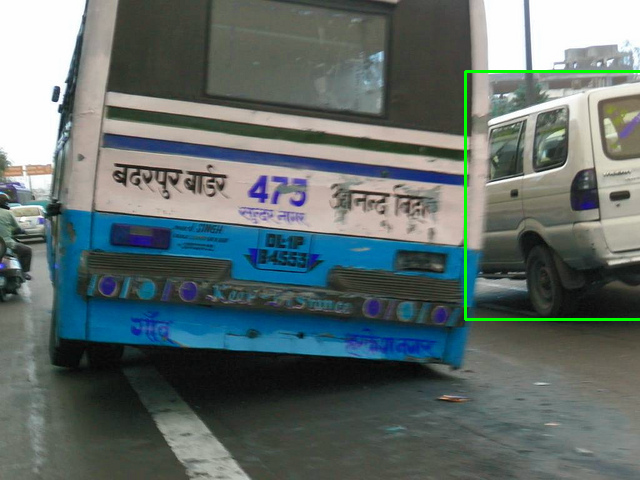

In [6]:
img_folder = 'val2017/'
img_name = img_names[4]
img = imread(img_folder + img_name)
if len(img.shape) == 2:
    img2 = np.zeros((np.array(img).shape[0], np.array(img).shape[1], 3))
    img2[:,:,0] = img # same value in each channel
    img2[:,:,1] = img
    img2[:,:,2] = img
    img = img2.astype(np.uint8)
yolo_img = pyyolo.array_to_image(img)
# Tiny
res = pyyolo.detect(net, meta, yolo_img)
for r in res:
    cv2.rectangle(img, r.bbox.get_point(pyyolo.BBox.Location.TOP_LEFT, is_int=True),
                    r.bbox.get_point(pyyolo.BBox.Location.BOTTOM_RIGHT, is_int=True), (0, 255, 0), 2)

cv2_imshow(img)

In [0]:
# Normal
res = pyyolo.detect(net2, meta, yolo_img)
for r in res:
    cv2.rectangle(img, r.bbox.get_point(pyyolo.BBox.Location.TOP_LEFT, is_int=True),
                    r.bbox.get_point(pyyolo.BBox.Location.BOTTOM_RIGHT, is_int=True), (0, 255, 0), 2)

cv2_imshow(img)